In [8]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from statsmodels.stats.contingency_tables import StratifiedTable

In [4]:
df = pd.read_csv('hw_aa.csv', sep=';')
df

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...,...
127013,127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127014,127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127015,127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127016,127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


* experimentVariant – вариант эксперимента
* version – версия приложения
* purchase – факт покупки

_____________________
* Запустите A/A-тест

* Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.

* Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)

* Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста

запускаем аа тест

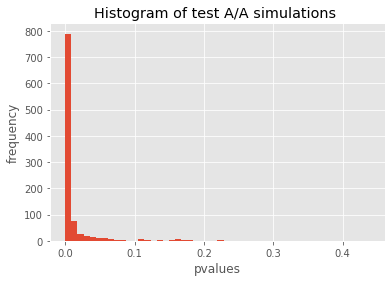

0.936

In [11]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# запуск симуляций аа теста
for i in tqdm(range(simulations)):
    s1 = df[df.experimentVariant == 1]['purchase'].sample(n_s, replace = False).values
    s2 = df[df.experimentVariant == 0]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) #сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title('Histogram of test A/A simulations ')
plt.show()

# проверяем что количество лодноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

In [ ]:
# по результатам теста видно, что FPR больше 0.05, соответственно сплитование некорректно

Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.

In [19]:
df.version.value_counts()

v2.8.0      82835
v2.9.0      23954
v3.8.0.0    11804
v3.7.4.0     8425
Name: version, dtype: int64

In [21]:
df.groupby(['experimentVariant', 'version'], as_index = False) \
    .agg({'purchase' : 'mean', 'Unnamed: 0' : 'count'})

,experimentVariant,version,purchase,Unnamed: 0
0,0,v2.8.0,0.000993,41283
1,0,v2.9.0,0.074658,11921
2,0,v3.7.4.0,0.059943,4204
3,0,v3.8.0.0,0.057604,5694
4,1,v2.8.0,0.045606,41552
5,1,v2.9.0,0.071304,12033
6,1,v3.7.4.0,0.063018,4221
7,1,v3.8.0.0,0.062848,6110


In [ ]:
# конверсия между группами version v2.8.0 сильно отличается 
# подставляем в симуляцию аа теста данные без version v2.8.0

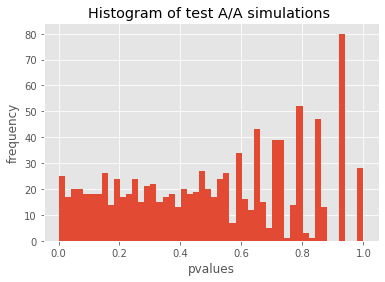

0.052

In [26]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# запуск симуляций аа теста
for i in tqdm(range(simulations)):
    s1 = df[(df.experimentVariant == 1) & (df.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    s2 = df[(df.experimentVariant == 0) & (df.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) #сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title('Histogram of test A/A simulations ')
plt.show()

# проверяем, что количество лодноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)

In [ ]:
# сплит-система сломалась так как было найдено различие в конверсии между группами version v2.8.0  

Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста

In [ ]:
# Первое сплитование было сделано некорректно, так как FPR было больше альфа. 
# Причина - различные данные между группами version v2.8.0. 
# После их исключения сплитование прошло корректно 